In [252]:
import pandas as pd
import numpy as np
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

import string 
from statistics import mean

import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

from random import shuffle

In [41]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\thegr\AppData\Roaming\nltk_data...


True

## Data Perparation 1: Data Frame Level 

Read Files

In [3]:
emails = pd.read_csv("emails.csv")

emails.head()

,Date,Subject,Assigned,Name,Full Comments,Company / Account,Contact,Opportunity
0,12/23/2020,Reply: Re: ABclonal Discount Quote,Hagop Abkarian,Jurgen Themen,"So sorry, these are the orders \n AP100...",Yale University - School of Medicine - Schwart...,Jurgen Themen,CA53242
1,12/23/2020,Email: Re: ABclonal Discount Quote,Hagop Abkarian,Jurgen Themen,https://app.salesloft.com/app/emails/detail/81...,Yale University - School of Medicine - Schwart...,Jurgen Themen,CA53242
2,12/23/2020,Email: Re: ABclonal Discount Quote,Hagop Abkarian,Jurgen Themen,https://app.salesloft.com/app/emails/detail/81...,Yale University - School of Medicine - Schwart...,Jurgen Themen,CA53242
3,12/23/2020,Email: Re: ABclonal Discount Quote,Hagop Abkarian,Jurgen Themen,https://app.salesloft.com/app/emails/detail/81...,Yale University - School of Medicine - Schwart...,Jurgen Themen,CA53242
4,12/23/2020,Reply: Re: ABclonal Discount Quote,Hagop Abkarian,Jurgen Themen,"Hi Hagop, \n Only 1 of each. \n Thanks, \n \n ...",Yale University - School of Medicine - Schwart...,Jurgen Themen,CA53242


Reorganize Dataframe

In [71]:
df = emails.replace(np.nan, " ")
df.index = pd.MultiIndex.from_arrays(df[["Company / Account", "Contact"]].values.T, names=['Company', 'Contact'])
df = df.drop(columns = ["Company / Account", "Contact"])

df = df.sort_values(by=["Company", "Contact"], ascending=True)
df = df.sort_values(by=["Date"], ascending=False)

df

,,Date,Subject,Assigned,Name,Full Comments,Opportunity
Company,Contact,,,,,,
McGill University - Murai Lab,Yorka Munoz,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Yorka Munoz,"To: ""Yorka Munoz"" <yorka.munozmunoz@mail.mcgil...",
Columbia University - Irving Medical Center - Institute for Cancer Genetics - Heravi Lab,Fatemeh Heravi,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Fatemeh Heravi,"To: ""Fatemeh Heravi"" <fm2540@cumc.columbia.edu...",
McGill University - McBride Lab,Julie Schwartz,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Julie Schwartz,"To: ""Julie Schwartz"" <julie.schwartz@mcgill.ca...",
McGill University - Komarova Lab,Josephine Tauer,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Josephine Tauer,"To: ""Josephine Tauer"" <jtauer@shriners.mcgill....",
University of Nebraska - Medical Center (UNMC),Palanisamy Nallasamy,9/9/2020,Email: Hoping to help your Research!,Deepu Devadas,Palanisamy Nallasamy,"To: ""Palanisamy Nallasamy"" <samy.nallasamy@unm...",
...,...,...,...,...,...,...,...
Harvard University - Harvard Medical School (HMS),Jane Liu,10/1/2020,Reply: Re: Custom Antibody Service inquiry,Hagop Abkarian,Jane Liu,"Hi Hagop,\n\nYeah sorry it took so long. We de...",AP53116
Florida Atlantic University,Tanja Godenschwege,10/1/2020,Email: ABclonal Custom Antibody Services,Laine Morris,Tanja Godenschwege,"To: ""Tanja Godenschwege"" <godensch@fau.edu>\n\...",
Emory University - Department of Radiation Oncology - Spangle Lab,Robert Brent Jones,10/1/2020,Email: PO number A375165,Tarang Upadhyaya,Robert Brent Jones,"To: ""Robert Brent Jones"" <robert.brent.jones@e...",CA90827


Find Company-Contact pairs that do and do not have opportunities

In [72]:
count_opps = emails.groupby(by=["Company / Account","Contact"]).count()

count_opps_T = count_opps.loc[count_opps.Opportunity > 0,] # have opportunities
count_opps_F = count_opps.loc[count_opps.Opportunity == 0,] # do not have opporunities

count_opps_T = count_opps_T[["Opportunity"]]
count_opps_F = count_opps_F[["Opportunity"]]

count_opps_T

Opportunity
Company / Account                                  Contact                            
Arizona State University (ASU)                     Dhenugen Logeswa                  1
Augusta University                                 Tianxiang Hu                      5
                                                   Xingguo zhu                      19
                                                   Yaoliang Tang                     4
Augusta University - Center for Biotechnology &... Shruti Sharma                     7
...                                                                                ...
Yale University - School of Medicine - De-Camil... Pietro De-Camilli                 1
Yale University - School of Medicine - Departme... Antonietta Bacchiocchi            4
Yale University - School of Medicine - Departme... Patrick Buckley                   3
                                                   Pengwei Zhang                     5
Yale University - School of Medicine - Schwartz... Jurgen Themen                     5

[576 rows x 1 columns]

Label each email

In [73]:
df.loc[count_opps_T.index,"Label"] = "Lead"
df.loc[count_opps_F.index,"Label"] = "No opp"
df.loc[df.Opportunity != " ", "Label"] = "Opp"

df

,,Date,Subject,Assigned,Name,Full Comments,Opportunity,Label
Company,Contact,,,,,,,
McGill University - Murai Lab,Yorka Munoz,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Yorka Munoz,"To: ""Yorka Munoz"" <yorka.munozmunoz@mail.mcgil...",,No opp
Columbia University - Irving Medical Center - Institute for Cancer Genetics - Heravi Lab,Fatemeh Heravi,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Fatemeh Heravi,"To: ""Fatemeh Heravi"" <fm2540@cumc.columbia.edu...",,No opp
McGill University - McBride Lab,Julie Schwartz,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Julie Schwartz,"To: ""Julie Schwartz"" <julie.schwartz@mcgill.ca...",,No opp
McGill University - Komarova Lab,Josephine Tauer,9/9/2020,Email: The WHEEL is back!,Tarang Upadhyaya,Josephine Tauer,"To: ""Josephine Tauer"" <jtauer@shriners.mcgill....",,No opp
University of Nebraska - Medical Center (UNMC),Palanisamy Nallasamy,9/9/2020,Email: Hoping to help your Research!,Deepu Devadas,Palanisamy Nallasamy,"To: ""Palanisamy Nallasamy"" <samy.nallasamy@unm...",,No opp
...,...,...,...,...,...,...,...,...
Harvard University - Harvard Medical School (HMS),Jane Liu,10/1/2020,Reply: Re: Custom Antibody Service inquiry,Hagop Abkarian,Jane Liu,"Hi Hagop,\n\nYeah sorry it took so long. We de...",AP53116,Opp
Florida Atlantic University,Tanja Godenschwege,10/1/2020,Email: ABclonal Custom Antibody Services,Laine Morris,Tanja Godenschwege,"To: ""Tanja Godenschwege"" <godensch@fau.edu>\n\...",,No opp
Emory University - Department of Radiation Oncology - Spangle Lab,Robert Brent Jones,10/1/2020,Email: PO number A375165,Tarang Upadhyaya,Robert Brent Jones,"To: ""Robert Brent Jones"" <robert.brent.jones@e...",CA90827,Opp


## Data Preparation 2: Text level 

Ensure that the emails are sent from ABclonal (not from contact)

In [134]:
cleaned = df[df['Full Comments'].str.contains("Body:")]
cleaned = cleaned[cleaned['Full Comments'].str.contains("ABclonal Technology | <http://www.abclonal.com/>")]

cleaned

Date  \
Company                                            Contact                           
McGill University - Murai Lab                      Yorka Munoz            9/9/2020   
Columbia University - Irving Medical Center - I... Fatemeh Heravi         9/9/2020   
McGill University - McBride Lab                    Julie Schwartz         9/9/2020   
McGill University - Komarova Lab                   Josephine Tauer        9/9/2020   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy   9/9/2020   
...                                                                            ...   
University of California (UC) - Davis              Holly Cagle           10/1/2020   
Harvard University - Harvard Medical School (HMS)  Jane Liu              10/1/2020   
                                                   Jane Liu              10/1/2020   
Emory University - Department of Radiation Onco... Robert Brent Jones    10/1/2020   
University of California - San Francisco (UCSF)    Lana Bogdanova        10/1/2020   

                                                                                                                   Subject  \
Company                                            Contact                                                                   
McGill University - Murai Lab                      Yorka Munoz                                   Email: The WHEEL is back!   
Columbia University - Irving Medical Center - I... Fatemeh Heravi                                Email: The WHEEL is back!   
McGill University - McBride Lab                    Julie Schwartz                                Email: The WHEEL is back!   
McGill University - Komarova Lab                   Josephine Tauer                               Email: The WHEEL is back!   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy               Email: Hoping to help your Research!   
...                                                                                                                    ...   
University of California (UC) - Davis              Holly Cagle           Email: Re:Welcoming you back with a 25% DISCOUNT!   
Harvard University - Harvard Medical School (HMS)  Jane Liu                     Email: Re: Custom Antibody Service inquiry   
                                                   Jane Liu                     Email: Re: Custom Antibody Service inquiry   
Emory University - Department of Radiation Onco... Robert Brent Jones                             Email: PO number A375165   
University of California - San Francisco (UCSF)    Lana Bogdanova        Email: Re:Welcoming you back with a 25% DISCOUNT!   

                                                                                 Assigned  \
Company                                            Contact                                  
McGill University - Murai Lab                      Yorka Munoz           Tarang Upadhyaya   
Columbia University - Irving Medical Center - I... Fatemeh Heravi        Tarang Upadhyaya   
McGill University - McBride Lab                    Julie Schwartz        Tarang Upadhyaya   
McGill University - Komarova Lab                   Josephine Tauer       Tarang Upadhyaya   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy     Deepu Devadas   
...                                                                                   ...   
University of California (UC) - Davis              Holly Cagle              Deepu Devadas   
Harvard University - Harvard Medical School (HMS)  Jane Liu                Hagop Abkarian   
                                                   Jane Liu                Hagop Abkarian   
Emory University - Department of Radiation Onco... Robert Brent Jones    Tarang Upadhyaya   
University of California - San Francisco (UCSF)    Lana Bogdanova           Deepu Devadas   

                                                                                         Name  \
Company      

"Full Comments" will only contain email body

In [136]:
cleaned['Full Comments'] = cleaned['Full Comments'].apply(lambda x: word_tokenize(x))
cleaned['Full Comments'] = cleaned['Full Comments'].apply(lambda x: " ".join(x))
cleaned['Full Comments'] = cleaned['Full Comments'].apply(lambda x: 
                            re.search('Body :(.*?)ABclonal Technology | < http : //www.abclonal.com/ >', str(x)).group(1))

cleaned

Date  \
Company                                            Contact                           
McGill University - Murai Lab                      Yorka Munoz            9/9/2020   
Columbia University - Irving Medical Center - I... Fatemeh Heravi         9/9/2020   
McGill University - McBride Lab                    Julie Schwartz         9/9/2020   
McGill University - Komarova Lab                   Josephine Tauer        9/9/2020   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy   9/9/2020   
...                                                                            ...   
University of California (UC) - Davis              Holly Cagle           10/1/2020   
Harvard University - Harvard Medical School (HMS)  Jane Liu              10/1/2020   
                                                   Jane Liu              10/1/2020   
Emory University - Department of Radiation Onco... Robert Brent Jones    10/1/2020   
University of California - San Francisco (UCSF)    Lana Bogdanova        10/1/2020   

                                                                                                                   Subject  \
Company                                            Contact                                                                   
McGill University - Murai Lab                      Yorka Munoz                                   Email: The WHEEL is back!   
Columbia University - Irving Medical Center - I... Fatemeh Heravi                                Email: The WHEEL is back!   
McGill University - McBride Lab                    Julie Schwartz                                Email: The WHEEL is back!   
McGill University - Komarova Lab                   Josephine Tauer                               Email: The WHEEL is back!   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy               Email: Hoping to help your Research!   
...                                                                                                                    ...   
University of California (UC) - Davis              Holly Cagle           Email: Re:Welcoming you back with a 25% DISCOUNT!   
Harvard University - Harvard Medical School (HMS)  Jane Liu                     Email: Re: Custom Antibody Service inquiry   
                                                   Jane Liu                     Email: Re: Custom Antibody Service inquiry   
Emory University - Department of Radiation Onco... Robert Brent Jones                             Email: PO number A375165   
University of California - San Francisco (UCSF)    Lana Bogdanova        Email: Re:Welcoming you back with a 25% DISCOUNT!   

                                                                                 Assigned  \
Company                                            Contact                                  
McGill University - Murai Lab                      Yorka Munoz           Tarang Upadhyaya   
Columbia University - Irving Medical Center - I... Fatemeh Heravi        Tarang Upadhyaya   
McGill University - McBride Lab                    Julie Schwartz        Tarang Upadhyaya   
McGill University - Komarova Lab                   Josephine Tauer       Tarang Upadhyaya   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy     Deepu Devadas   
...                                                                                   ...   
University of California (UC) - Davis              Holly Cagle              Deepu Devadas   
Harvard University - Harvard Medical School (HMS)  Jane Liu                Hagop Abkarian   
                                                   Jane Liu                Hagop Abkarian   
Emory University - Department of Radiation Onco... Robert Brent Jones    Tarang Upadhyaya   
University of California - San Francisco (UCSF)    Lana Bogdanova           Deepu Devadas   

                                                                                         Name  \
Company      

In [151]:
cleaned = cleaned[cleaned["Full Comments"].isna() == False]

Some data frames for further study

In [152]:
# directly linked to opps
df_opps_T = cleaned[cleaned['Label'] == "Opp"]

# not related to opps
df_opps_F = cleaned[cleaned['Label'] == "No opp"]

# lead to opps
df_opps_L = cleaned[cleaned['Label'] == "Lead"]

## Keyword Analysis 

In [155]:
comments_opps_T = list(df_opps_T["Full Comments"])
comments_opps_F = list(df_opps_F["Full Comments"])
comments_opps_L = list(df_opps_L["Full Comments"])

text_opps_T = " ".join(comments_opps_T)
text_opps_F = " ".join(comments_opps_F)
text_opps_L = " ".join(comments_opps_L)

words_T = word_tokenize(text_opps_T)
words_F = word_tokenize(text_opps_F)
words_L = word_tokenize(text_opps_L)

Clean the words

In [245]:
stopwords = nltk.corpus.stopwords.words("english")
names = nltk.corpus.names.words()

words_clean_T = [w for w in words_T if w.isalpha()]
words_clean_F = [w for w in words_F if w.isalpha()]
words_clean_L = [w for w in words_L if w.isalpha()]

words_clean_T = [w for w in words_clean_T if w not in names]
words_clean_F = [w for w in words_clean_F if w not in names]
words_clean_L = [w for w in words_clean_L if w not in names]

words_clean_T = [w.lower() for w in words_clean_T if w.lower() not in stopwords]
words_clean_F = [w.lower() for w in words_clean_F if w.lower() not in stopwords]
words_clean_L = [w.lower() for w in words_clean_L if w.lower() not in stopwords]

In [164]:
fd_T = FreqDist(words_clean_T)
fd_F = FreqDist(words_clean_F)
fd_L = FreqDist(words_clean_L)

In [167]:
print(fd_T.most_common(50))

[('hi', 1645), ('best', 1418), ('sales', 1083), ('please', 1066), ('know', 992), ('https', 904), ('let', 891), ('antibody', 888), ('quote', 821), ('free', 717), ('email', 716), ('would', 668), ('antibodies', 627), ('abclonal', 598), ('ayres', 585), ('order', 584), ('specialist', 573), ('sent', 563), ('franco', 541), ('cayres', 517), ('hagop', 516), ('associate', 512), ('subject', 511), ('well', 507), ('thanks', 500), ('help', 489), ('field', 488), ('technical', 480), ('also', 466), ('attached', 457), ('pm', 441), ('questions', 419), ('development', 413), ('samples', 413), ('regards', 403), ('deepu', 394), ('happy', 387), ('send', 375), ('manager', 366), ('account', 360), ('thank', 354), ('get', 342), ('laine', 340), ('see', 334), ('tel', 317), ('elisa', 309), ('hope', 307), ('representative', 303), ('antigen', 299), ('forward', 296)]


In [168]:
print(fd_F.most_common(50))

[('https', 15719), ('free', 14212), ('please', 13917), ('hi', 12886), ('happy', 10588), ('help', 8706), ('antibody', 8632), ('deepu', 8621), ('also', 8243), ('regards', 8207), ('abclonal', 8145), ('hagop', 7792), ('products', 7615), ('best', 7563), ('antibodies', 7205), ('development', 7137), ('catalog', 7089), ('know', 6902), ('research', 6608), ('samples', 6588), ('representative', 6429), ('well', 6363), ('order', 6343), ('let', 6011), ('sales', 5766), ('would', 5338), ('provide', 5181), ('offer', 5045), ('lab', 4951), ('email', 4913), ('feel', 4860), ('abkarian', 4760), ('reach', 4718), ('specialist', 4455), ('great', 4080), ('send', 4057), ('questions', 3979), ('field', 3971), ('qpcr', 3822), ('next', 3780), ('back', 3720), ('find', 3595), ('discount', 3413), ('number', 3377), ('hope', 3152), ('contact', 3109), ('promotion', 2985), ('forward', 2982), ('get', 2935), ('dr', 2892)]


In [169]:
print(fd_L.most_common(50))

[('hi', 1686), ('order', 1327), ('best', 1279), ('https', 1136), ('sales', 1039), ('please', 832), ('know', 780), ('let', 769), ('free', 721), ('thank', 715), ('antibody', 705), ('email', 701), ('antibodies', 662), ('abclonal', 632), ('ayres', 627), ('number', 623), ('sent', 620), ('cayres', 604), ('technical', 582), ('specialist', 577), ('subject', 556), ('pm', 546), ('would', 502), ('franco', 493), ('associate', 465), ('send', 459), ('hagop', 450), ('well', 441), ('also', 432), ('tracking', 426), ('thanks', 423), ('field', 423), ('help', 418), ('samples', 400), ('team', 395), ('tel', 368), ('address', 364), ('quote', 363), ('elisa', 361), ('get', 357), ('shipped', 353), ('manager', 347), ('cc', 345), ('research', 339), ('regards', 329), ('sample', 326), ('account', 325), ('shipping', 323), ('us', 320), ('yian', 320)]


In [170]:
finder_bi_T = nltk.collocations.BigramCollocationFinder.from_words(words_clean_T)
finder_bi_F = nltk.collocations.BigramCollocationFinder.from_words(words_clean_F)
finder_bi_L = nltk.collocations.BigramCollocationFinder.from_words(words_clean_L)

finder_tri_T = nltk.collocations.TrigramCollocationFinder.from_words(words_clean_T)
finder_tri_F = nltk.collocations.TrigramCollocationFinder.from_words(words_clean_F)
finder_tri_L = nltk.collocations.TrigramCollocationFinder.from_words(words_clean_L)

finder_qua_T = nltk.collocations.QuadgramCollocationFinder.from_words(words_clean_T)
finder_qua_F = nltk.collocations.QuadgramCollocationFinder.from_words(words_clean_F)
finder_qua_L = nltk.collocations.QuadgramCollocationFinder.from_words(words_clean_L)

In [174]:
print(finder_bi_T.ngram_fd.most_common(20))

[(('let', 'know'), 835), (('sales', 'specialist'), 554), (('field', 'sales'), 487), (('technical', 'sales'), 451), (('sales', 'associate'), 431), (('specialist', 'hi'), 403), (('best', 'technical'), 360), (('ayres', 'cayres'), 341), (('associate', 'hi'), 334), (('account', 'manager'), 324), (('https', 'https'), 293), (('please', 'let'), 289), (('development', 'representative'), 273), (('hagop', 'abkarian'), 273), (('feel', 'free'), 267), (('best', 'franco'), 266), (('franco', 'franco'), 266), (('tel', 'email'), 264), (('franco', 'field'), 250), (('deepu', 'development'), 229)]


In [175]:
print(finder_bi_F.ngram_fd.most_common(20))

[(('https', 'https'), 6208), (('development', 'representative'), 6152), (('let', 'know'), 5866), (('deepu', 'development'), 5761), (('representative', 'hi'), 5014), (('free', 'samples'), 4924), (('feel', 'free'), 4852), (('hagop', 'abkarian'), 4760), (('sales', 'specialist'), 4070), (('field', 'sales'), 3968), (('regards', 'deepu'), 3950), (('regards', 'hagop'), 3727), (('specialist', 'hi'), 3584), (('abkarian', 'field'), 3552), (('please', 'find'), 3526), (('find', 'products'), 3462), (('please', 'feel'), 3421), (('send', 'free'), 3396), (('hagop', 'hagop'), 3016), (('products', 'https'), 2939)]


In [176]:
print(finder_bi_L.ngram_fd.most_common(20))

[(('let', 'know'), 671), (('sales', 'specialist'), 564), (('technical', 'sales'), 547), (('best', 'technical'), 454), (('field', 'sales'), 423), (('sales', 'associate'), 411), (('ayres', 'cayres'), 390), (('https', 'https'), 360), (('specialist', 'hi'), 346), (('associate', 'hi'), 328), (('account', 'manager'), 309), (('yian', 'ywang'), 271), (('please', 'let'), 250), (('tel', 'email'), 242), (('hagop', 'abkarian'), 235), (('best', 'franco'), 235), (('franco', 'franco'), 229), (('cell', 'tel'), 223), (('email', 'cayres'), 214), (('tracking', 'number'), 211)]


Opp

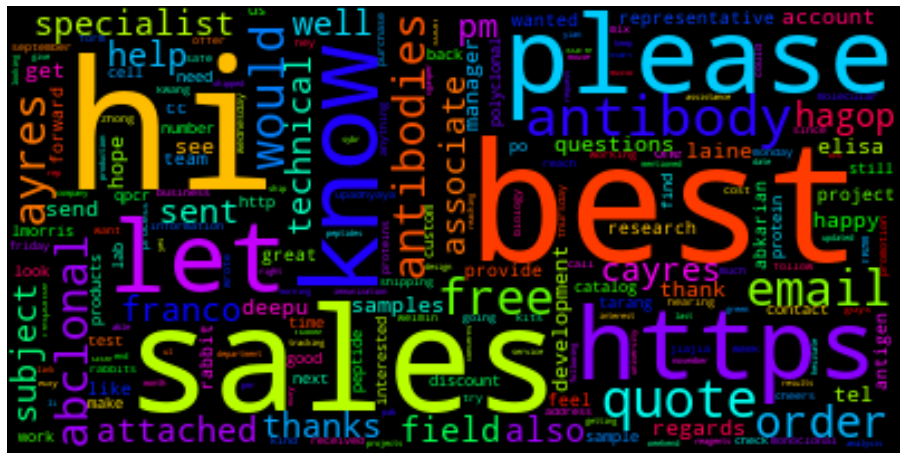

In [178]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(fd_T)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

No Opp

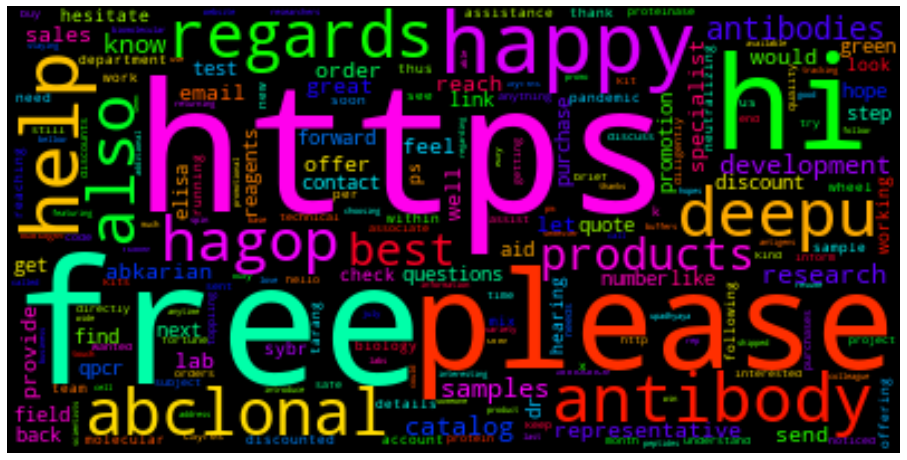

In [179]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(fd_F)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Lead

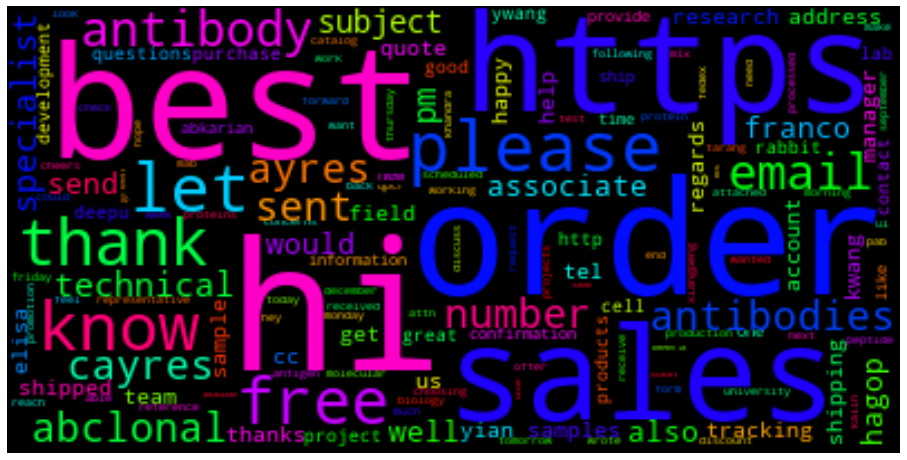

In [180]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(fd_L)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Opp

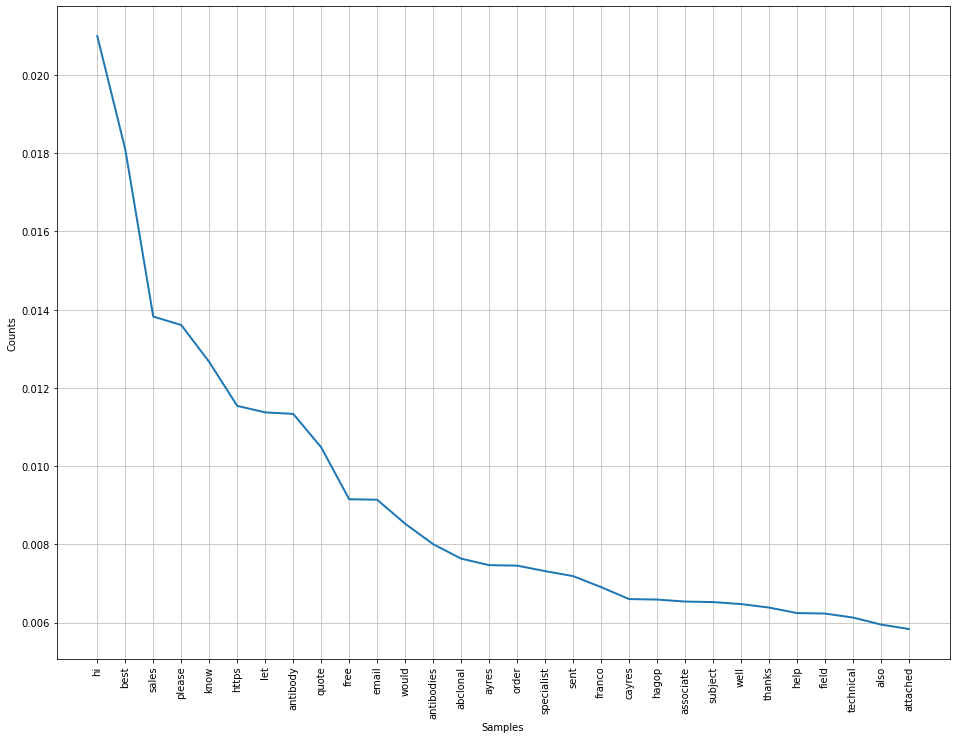

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [185]:
total = sum(fd_T.values())
for key in fd_T.keys():
    fd_T[key] = fd_T[key]/total
    
plt.figure(figsize=(16,12))
fd_T.plot(30)

No Opp

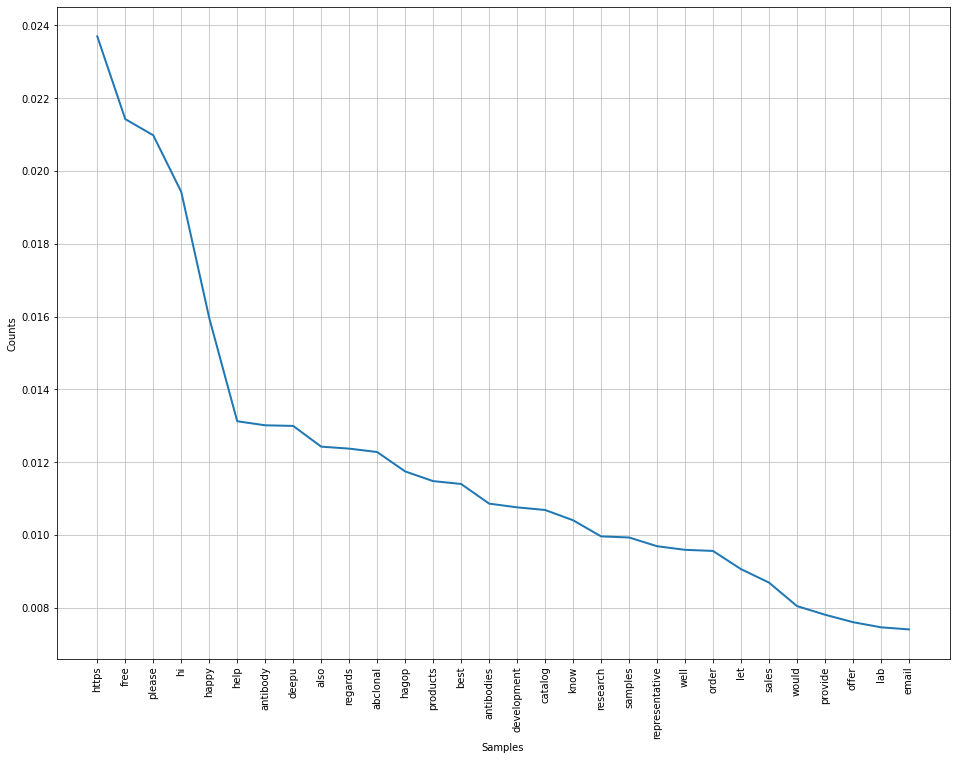

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [186]:
total = sum(fd_F.values())
for key in fd_F.keys():
    fd_F[key] = fd_F[key]/total
    
plt.figure(figsize=(16,12))
fd_F.plot(30)

Lead

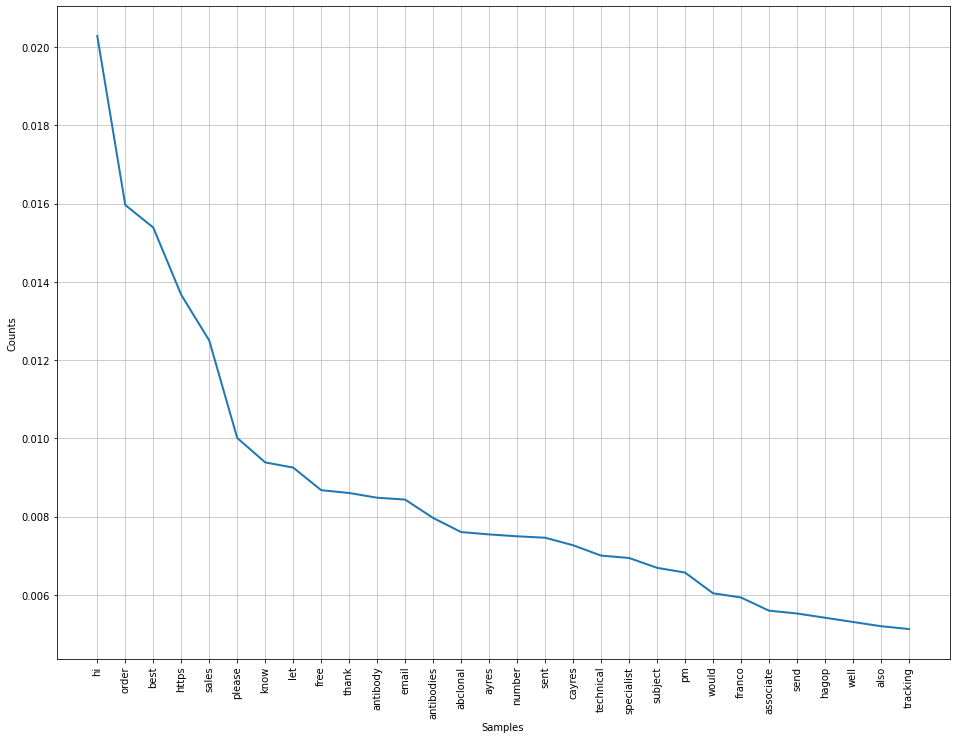

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [187]:
total = sum(fd_L.values())
for key in fd_L.keys():
    fd_L[key] = fd_L[key]/total
    
plt.figure(figsize=(16,12))
fd_L.plot(30)

## Built-in Sentiment Classifier 

In [205]:
cleaned["Score"] = cleaned["Full Comments"].apply(lambda x: 
                            sum([sia.polarity_scores(sent)['compound'] for sent in nltk.sent_tokenize(x)]))
cleaned["Neg"] = cleaned["Full Comments"].apply(lambda x: 
                            sum([sia.polarity_scores(sent)['neg'] for sent in nltk.sent_tokenize(x)]))
cleaned["Pos"] = cleaned["Full Comments"].apply(lambda x: 
                            sum([sia.polarity_scores(sent)['pos'] for sent in nltk.sent_tokenize(x)]))

cleaned

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Date  \
Company                                            Contact                           
McGill University - Murai Lab                      Yorka Munoz            9/9/2020   
Columbia University - Irving Medical Center - I... Fatemeh Heravi         9/9/2020   
McGill University - McBride Lab                    Julie Schwartz         9/9/2020   
McGill University - Komarova Lab                   Josephine Tauer        9/9/2020   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy   9/9/2020   
...                                                                            ...   
University of California (UC) - Davis              Holly Cagle           10/1/2020   
Harvard University - Harvard Medical School (HMS)  Jane Liu              10/1/2020   
                                                   Jane Liu              10/1/2020   
Emory University - Department of Radiation Onco... Robert Brent Jones    10/1/2020   
University of California - San Francisco (UCSF)    Lana Bogdanova        10/1/2020   

                                                                                                                   Subject  \
Company                                            Contact                                                                   
McGill University - Murai Lab                      Yorka Munoz                                   Email: The WHEEL is back!   
Columbia University - Irving Medical Center - I... Fatemeh Heravi                                Email: The WHEEL is back!   
McGill University - McBride Lab                    Julie Schwartz                                Email: The WHEEL is back!   
McGill University - Komarova Lab                   Josephine Tauer                               Email: The WHEEL is back!   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy               Email: Hoping to help your Research!   
...                                                                                                                    ...   
University of California (UC) - Davis              Holly Cagle           Email: Re:Welcoming you back with a 25% DISCOUNT!   
Harvard University - Harvard Medical School (HMS)  Jane Liu                     Email: Re: Custom Antibody Service inquiry   
                                                   Jane Liu                     Email: Re: Custom Antibody Service inquiry   
Emory University - Department of Radiation Onco... Robert Brent Jones                             Email: PO number A375165   
University of California - San Francisco (UCSF)    Lana Bogdanova        Email: Re:Welcoming you back with a 25% DISCOUNT!   

                                                                                 Assigned  \
Company                                            Contact                                  
McGill University - Murai Lab                      Yorka Munoz           Tarang Upadhyaya   
Columbia University - Irving Medical Center - I... Fatemeh Heravi        Tarang Upadhyaya   
McGill University - McBride Lab                    Julie Schwartz        Tarang Upadhyaya   
McGill University - Komarova Lab                   Josephine Tauer       Tarang Upadhyaya   
University of Nebraska - Medical Center (UNMC)     Palanisamy Nallasamy     Deepu Devadas   
...                                                                                   ...   
University of California (UC) - Davis              Holly Cagle              Deepu Devadas   
Harvard University - Harvard Medical School (HMS)  Jane Liu                Hagop Abkarian   
                                                   Jane Liu                Hagop Abkarian   
Emory University - Department of Radiation Onco... Robert Brent Jones    Tarang Upadhyaya   
University of California - San Francisco (UCSF)    Lana Bogdanova           Deepu Devadas   

                                                                                         Name  \
Company      

Compound Score

In [206]:
[("Opp:",mean(cleaned.loc[cleaned.Label == "Opp","Score"])),
 ("No Opp:",mean(cleaned.loc[cleaned.Label == "No opp","Score"])),
 ("Lead:",mean(cleaned.loc[cleaned.Label == "Lead","Score"]))]

[('Opp:', 2.3967571721311476),
 ('No Opp:', 2.6055491107871718),
 ('Lead:', 2.239143552631579)]

Positive Score

In [203]:
[("Opp:",mean(cleaned.loc[cleaned.Label == "Opp","Pos"])),
 ("No Opp:",mean(cleaned.loc[cleaned.Label == "No opp","Pos"])),
 ("Lead:",mean(cleaned.loc[cleaned.Label == "Lead","Pos"]))]

[('Opp:', 1.5220963114754098),
 ('No Opp:', 1.4494751457725947),
 ('Lead:', 1.428283552631579)]

Negative Score

In [204]:
[("Opp:",mean(cleaned.loc[cleaned.Label == "Opp","Neg"])),
 ("No Opp:",mean(cleaned.loc[cleaned.Label == "No opp","Neg"])),
 ("Lead:",mean(cleaned.loc[cleaned.Label == "Lead","Neg"]))]

[('Opp:', 0.11957513661202186),
 ('No Opp:', 0.05195043731778426),
 ('Lead:', 0.10022236842105263)]

## Use the Logistic Model to Test if Sentiment Label is Correct 

In [209]:
dfNew = cleaned[['Full Comments','Label']]

dfNew.loc[dfNew.Label=="No opp", 'Sentiment'] = -1
dfNew.loc[dfNew.Label!="No opp", 'Sentiment'] = 1

dfNew = dfNew.reset_index()[['Full Comments', 'Sentiment']]
dfNew

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Full Comments,Sentiment
0,"Hi Yorka , Hope all is well . I was reaching ...",-1.0
1,"Hi Dr. Heravi , Hope all is well . I was reac...",-1.0
2,"Hi Julie , Hope all is well . I was reaching ...",-1.0
3,"Hi Josephine , Hope all is well . I was reach...",-1.0
4,"Hi Dr Palanisamy , Hope you are doing great !...",-1.0
...,...,...
21763,"Hi Dr Cagle , Hope you are doing great ! To a...",-1.0
21764,"Hi Jane , I hope you are doing well . I wante...",1.0
21765,"Hi Jane , No worries , thank you for letting ...",1.0
21766,"Hi Robert , How are you ? My name is Tarang a...",1.0


Model preparation

In [212]:
index = dfNew.index
dfNew['random_number'] = np.random.randn(len(index))

train = dfNew[dfNew['random_number'] <= 0.8]
test = dfNew[dfNew['random_number'] > 0.8]

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Full Comments'])
test_matrix = vectorizer.transform(test['Full Comments'])

X_train = train_matrix
X_test = test_matrix
y_train = train['Sentiment']
y_test = test['Sentiment']

Fit model and predict on test set

In [217]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)

predictions = lr.predict(X_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

        -1.0       0.89      0.83      0.86      3236
         1.0       0.69      0.79      0.73      1514

    accuracy                           0.82      4750
   macro avg       0.79      0.81      0.80      4750
weighted avg       0.83      0.82      0.82      4750



Majority Class

In [218]:
len(dfNew[dfNew['Sentiment']==-1])/len(dfNew)

0.6302829841969864

## Custom Classifier 

Define dictionaries for positive words and negative words

In [246]:
positive_words = list(np.append(words_clean_T,words_clean_L))
negative_words = words_clean_F

positive_fd = FreqDist(positive_words)
negative_fd = FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = {word for word, count in positive_fd.most_common(100)}
top_100_negative = {word for word, count in negative_fd.most_common(100)}

Customize features that determine the "scores" of a given text

In [247]:
def extract_features(text):
    features = dict()
    wordcount = 0
    compound_scores = list()
    positive_scores = list()

    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in top_100_positive:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])

    features["mean_compound"] = mean(compound_scores) + 1
    features["mean_positive"] = mean(positive_scores)
    features["wordcount"] = wordcount

    return features

Test the accuracy of the classifer with the custom features

In [250]:
features = [
    (extract_features(email), "pos")
    for email in list(dfNew.loc[dfNew.Sentiment == 1, "Full Comments"])
]

features.extend([
    (extract_features(email), "neg")
    for email in list(dfNew.loc[dfNew.Sentiment == -1, "Full Comments"])
])

In [253]:
train_count = len(features) // 4
shuffle(features)
classifier = nltk.NaiveBayesClassifier.train(features[:train_count])
classifier.show_most_informative_features(10)
nltk.classify.accuracy(classifier, features[train_count:])

Most Informative Features
           mean_positive = 0.124             pos : neg    =     40.4 : 1.0
           mean_positive = 0.165             neg : pos    =     36.3 : 1.0
           mean_compound = 1.3913            neg : pos    =     14.2 : 1.0
           mean_compound = 1.4480181818181819    neg : pos    =     14.1 : 1.0
           mean_positive = 0.1712857142857143    neg : pos    =     14.0 : 1.0
           mean_positive = 0.21163636363636362    neg : pos    =     13.8 : 1.0
           mean_compound = 1.3472833333333334    neg : pos    =     13.4 : 1.0
           mean_positive = 0.21033333333333334    neg : pos    =     13.2 : 1.0
           mean_positive = 0.3566666666666667    neg : pos    =     12.8 : 1.0
           mean_compound = 1.453575          pos : neg    =     12.8 : 1.0


0.7744089182898444